In [1]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

import sys
sys.path.append('/cephfs/home/lc865/workspace/similar-expressions/src')

In [ ]:
from tqdm import tqdm

# Define both experiment paths
experiment_paths = {
    'neural': '/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/sept-baseline-4-neural',
    'vanilla': '/cephfs/store/gr-mc2473/lc865/workspace/benchmark_data/sept-baseline-4-vanilla'
}

# Load all tensorboard_scalars.csv files and combine them
all_data = []
for setup_name, experiment_path in experiment_paths.items():
    run_names = [run_name for run_name in os.listdir(experiment_path) if run_name.startswith('pysr-univariate_eq') and '_run' in run_name]
    
    for run_name in tqdm(run_names, desc=f"Loading {setup_name} tensorboard data"):
        csv_path = os.path.join(experiment_path, run_name, 'tensorboard_scalars.csv')
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            df['run_name'] = run_name
            df['setup'] = setup_name
            all_data.append(df)

# Combine all dataframes into one large table
combined_df = pd.concat(all_data, ignore_index=True)
# Extract dataset, equation, and run number from run_name
combined_df[['dataset', 'eq', 'run']] = combined_df['run_name'].str.extract(r'pysr-(\w+)_eq(\d+)_run(\d+)')
combined_df['eq'] = combined_df['eq'].astype(int)
combined_df['run'] = combined_df['run'].astype(int)

LOSS_LOWER_BOUND = 1e-8
combined_df['min_loss'] = combined_df['min_loss'].clip(lower=LOSS_LOWER_BOUND)
loss_columns = [col for col in combined_df.columns if col.startswith('loss_') and col[5:].isdigit()]
for col in loss_columns:
    combined_df[col] = combined_df[col].clip(lower=LOSS_LOWER_BOUND)

print(f"Loaded data from {len(all_data)} runs with {len(combined_df)} total rows")
print(f"Setup distribution: {combined_df['setup'].value_counts().to_dict()}")

Loading vanilla tensorboard data: 100%|██████████| 1190/1190 [00:25<00:00, 46.20it/s]


Loaded data from 2158 runs with 1705313 total rows
Setup distribution: {'vanilla': 951754, 'neural': 753559}


In [26]:
# Check unique run_name and setup combinations
print("Checking unique run_name and setup combinations:")
unique_combinations = combined_df[['run_name', 'setup']].drop_duplicates()
print(f"Total unique run_name and setup combinations: {len(unique_combinations)}")

# Check if any run_name appears with multiple setups
run_name_setup_counts = combined_df.groupby('run_name')['setup'].nunique()
multi_setup_runs = run_name_setup_counts[run_name_setup_counts > 1]
if len(multi_setup_runs) > 0:
    print(f"WARNING: {len(multi_setup_runs)} run_names appear with multiple setups:")
    print(multi_setup_runs.head())
else:
    print("Good: Each run_name appears with only one setup")

# Vectorized approach: For each (run_name, setup) combination, find the last entry (by step)
# First, find the maximum step for each (run_name, setup) combination
max_steps = combined_df.groupby(['run_name', 'setup'])['step'].idxmax()

# Use these indices to get the final results directly
final_results_df = combined_df.loc[max_steps, ['run_name', 'setup', 'step', 'min_loss', 'pareto_volume']].copy()

# Rename columns to match the original structure
final_results_df = final_results_df.rename(columns={
    'step': 'final_step',
    'min_loss': 'final_min_loss',
    'pareto_volume': 'final_pareto_volume'
})

# Reset index to get a clean dataframe
final_results_df = final_results_df.reset_index(drop=True)

print(f"Final results table with {len(final_results_df)} runs:")
final_results_df.head()

Checking unique run_name and setup combinations:
Total unique run_name and setup combinations: 2158
run_name
pysr-univariate_eq0_run0    2
pysr-univariate_eq0_run1    2
pysr-univariate_eq0_run2    2
pysr-univariate_eq0_run3    2
pysr-univariate_eq0_run4    2
Name: setup, dtype: int64
Final results table with 2158 runs:


,run_name,setup,final_step,final_min_loss,final_pareto_volume
0,pysr-univariate_eq0_run0,neural,1,1.000000e-08,0.000000
1,pysr-univariate_eq0_run0,vanilla,1,1.000000e-08,0.000000
2,pysr-univariate_eq0_run1,neural,1,1.000000e-08,0.000051
3,pysr-univariate_eq0_run1,vanilla,1,1.000000e-08,0.000000
4,pysr-univariate_eq0_run2,neural,1,1.000000e-08,0.000000


In [27]:
# Extract dataset, equation, and run number from run_name
final_results_df[['dataset', 'eq', 'run']] = final_results_df['run_name'].str.extract(r'pysr-(\w+)_eq(\d+)_run(\d+)')
final_results_df['eq'] = final_results_df['eq'].astype(int)
final_results_df['run'] = final_results_df['run'].astype(int)

# Count runs per equation and setup
run_counts = final_results_df.groupby(['dataset', 'eq', 'setup']).size().reset_index(name='n_runs')
print("Run counts per equation and setup:")
print(run_counts.head(10))

# Find equations that have at least 10 runs for BOTH setups
equations_with_enough_runs_both = run_counts[run_counts['n_runs'] >= 10].groupby(['dataset', 'eq']).size().reset_index(name='setup_count')
equations_with_enough_runs_both = equations_with_enough_runs_both[equations_with_enough_runs_both['setup_count'] >= 2][['dataset', 'eq']]
print(f"\nEquations with at least 10 runs for both setups: {len(equations_with_enough_runs_both)}")

# Filter to only include these equations
filtered_df = final_results_df.merge(equations_with_enough_runs_both, on=['dataset', 'eq'], how='inner')
print(f"Filtered to {len(filtered_df)} runs from {filtered_df['eq'].nunique()} equations")

# Calculate mean and std for final_min_loss and final_pareto_volume by equation and setup
summary_stats = filtered_df.groupby(['dataset', 'eq', 'setup']).agg({
    'final_min_loss': ['mean', 'std', 'count'],
    'final_pareto_volume': ['mean', 'std', 'count']
})

# Flatten column names
summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns]
summary_stats = summary_stats.reset_index()

print(f"\nSummary statistics for {len(summary_stats)} equation-setup combinations:")
summary_stats.head(10)


Run counts per equation and setup:
      dataset  eq    setup  n_runs
0  univariate   0   neural      10
1  univariate   0  vanilla      10
2  univariate   1   neural      10
3  univariate   1  vanilla      10
4  univariate   2   neural      10
5  univariate   2  vanilla      10
6  univariate   3   neural      10
7  univariate   3  vanilla      10
8  univariate   4   neural      10
9  univariate   4  vanilla      10

Equations with at least 10 runs for both setups: 96
Filtered to 1920 runs from 96 equations

Summary statistics for 192 equation-setup combinations:


,dataset,eq,setup,final_min_loss_mean,final_min_loss_std,final_min_loss_count,final_pareto_volume_mean,final_pareto_volume_std,final_pareto_volume_count
0,univariate,0,neural,1.000000e-08,0.000000e+00,10,1.165520,2.457617,10
1,univariate,0,vanilla,1.000000e-08,0.000000e+00,10,1.348468,2.844379,10
2,univariate,1,neural,4.012288e-06,1.703640e-07,10,7.111163,0.043329,10
3,univariate,1,vanilla,4.043515e-06,1.538858e-07,10,7.100973,0.020740,10
4,univariate,2,neural,1.000690e-06,1.025855e-06,10,6.195608,0.444408,10
5,univariate,2,vanilla,2.195000e-06,2.046788e-06,10,5.788876,0.646027,10
6,univariate,3,neural,1.479767e-06,3.888950e-08,10,7.930941,0.013430,10
7,univariate,3,vanilla,1.511715e-06,4.249565e-08,10,7.879608,0.141533,10
8,univariate,4,neural,1.000000e-08,0.000000e+00,10,5.335593,1.019248,10
9,univariate,4,vanilla,1.000000e-08,0.000000e+00,10,5.536855,1.166051,10


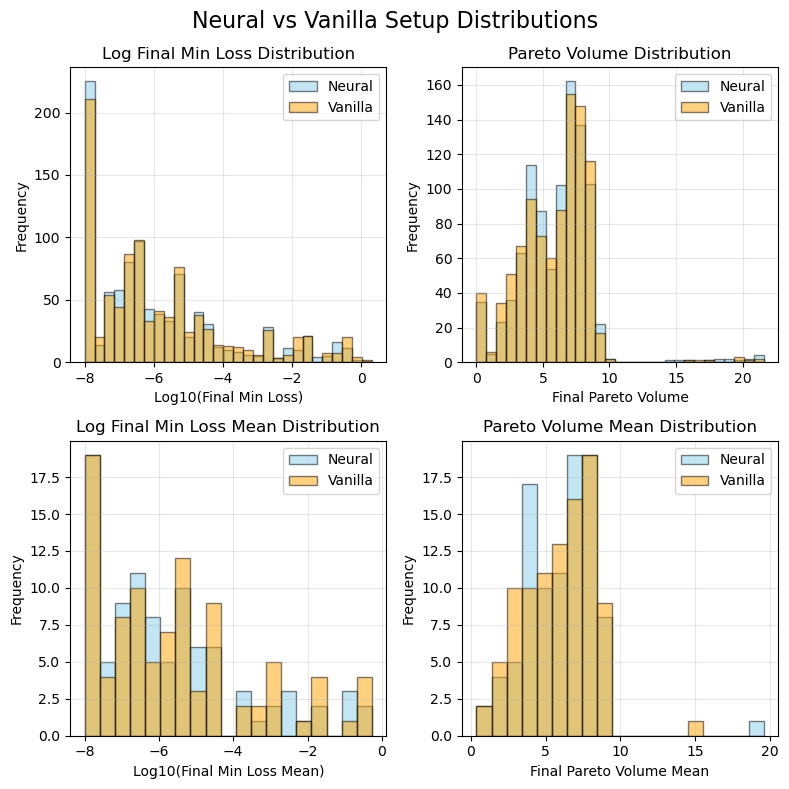

In [28]:
# Create histograms for neural and vanilla setup distributions
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle('Neural vs Vanilla Setup Distributions', fontsize=16)

# Filter for neural and vanilla setups
neural_df = filtered_df[filtered_df['setup'] == 'neural']
vanilla_df = filtered_df[filtered_df['setup'] == 'vanilla']

# Plot 1: Log Final Min Loss histogram
ax1 = axes[0, 0]
log_loss_neural = np.log10(neural_df['final_min_loss'])
log_loss_vanilla = np.log10(vanilla_df['final_min_loss'])

# Create common bins for log loss
log_loss_min = min(log_loss_neural.min(), log_loss_vanilla.min())
log_loss_max = max(log_loss_neural.max(), log_loss_vanilla.max())
log_loss_bins = np.linspace(log_loss_min, log_loss_max, 30)

ax1.hist(log_loss_neural, bins=log_loss_bins, alpha=0.5, color='skyblue', edgecolor='black', label='Neural')
ax1.hist(log_loss_vanilla, bins=log_loss_bins, alpha=0.5, color='orange', edgecolor='black', label='Vanilla')
ax1.set_xlabel('Log10(Final Min Loss)')
ax1.set_ylabel('Frequency')
ax1.set_title('Log Final Min Loss Distribution')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Pareto Volume histogram
ax2 = axes[0, 1]

# Create common bins for pareto volume
pareto_min = min(neural_df['final_pareto_volume'].min(), vanilla_df['final_pareto_volume'].min())
pareto_max = max(neural_df['final_pareto_volume'].max(), vanilla_df['final_pareto_volume'].max())
pareto_bins = np.linspace(pareto_min, pareto_max, 30)

ax2.hist(neural_df['final_pareto_volume'], bins=pareto_bins, alpha=0.5, color='skyblue', edgecolor='black', label='Neural')
ax2.hist(vanilla_df['final_pareto_volume'], bins=pareto_bins, alpha=0.5, color='orange', edgecolor='black', label='Vanilla')
ax2.set_xlabel('Final Pareto Volume')
ax2.set_ylabel('Frequency')
ax2.set_title('Pareto Volume Distribution')
ax2.grid(True, alpha=0.3)
ax2.legend()
# Plot 3: Final Min Loss means histogram
ax3 = axes[1, 0]

# Get means from summary_stats for neural and vanilla
neural_means = summary_stats[summary_stats['setup'] == 'neural']['final_min_loss_mean']
vanilla_means = summary_stats[summary_stats['setup'] == 'vanilla']['final_min_loss_mean']

# Create common bins for log loss means
log_loss_neural_means = np.log10(neural_means)
log_loss_vanilla_means = np.log10(vanilla_means)

log_loss_means_min = min(log_loss_neural_means.min(), log_loss_vanilla_means.min())
log_loss_means_max = max(log_loss_neural_means.max(), log_loss_vanilla_means.max())
log_loss_means_bins = np.linspace(log_loss_means_min, log_loss_means_max, 20)

ax3.hist(log_loss_neural_means, bins=log_loss_means_bins, alpha=0.5, color='skyblue', edgecolor='black', label='Neural')
ax3.hist(log_loss_vanilla_means, bins=log_loss_means_bins, alpha=0.5, color='orange', edgecolor='black', label='Vanilla')
ax3.set_xlabel('Log10(Final Min Loss Mean)')
ax3.set_ylabel('Frequency')
ax3.set_title('Log Final Min Loss Mean Distribution')
ax3.grid(True, alpha=0.3)
ax3.legend()

# Plot 4: Pareto Volume means histogram
ax4 = axes[1, 1]

# Get means from summary_stats for neural and vanilla
neural_pareto_means = summary_stats[summary_stats['setup'] == 'neural']['final_pareto_volume_mean']
vanilla_pareto_means = summary_stats[summary_stats['setup'] == 'vanilla']['final_pareto_volume_mean']

# Create common bins for pareto volume means
pareto_means_min = min(neural_pareto_means.min(), vanilla_pareto_means.min())
pareto_means_max = max(neural_pareto_means.max(), vanilla_pareto_means.max())
pareto_means_bins = np.linspace(pareto_means_min, pareto_means_max, 20)

ax4.hist(neural_pareto_means, bins=pareto_means_bins, alpha=0.5, color='skyblue', edgecolor='black', label='Neural')
ax4.hist(vanilla_pareto_means, bins=pareto_means_bins, alpha=0.5, color='orange', edgecolor='black', label='Vanilla')
ax4.set_xlabel('Final Pareto Volume Mean')
ax4.set_ylabel('Frequency')
ax4.set_title('Pareto Volume Mean Distribution')
ax4.grid(True, alpha=0.3)
ax4.legend()

plt.tight_layout()
plt.show()


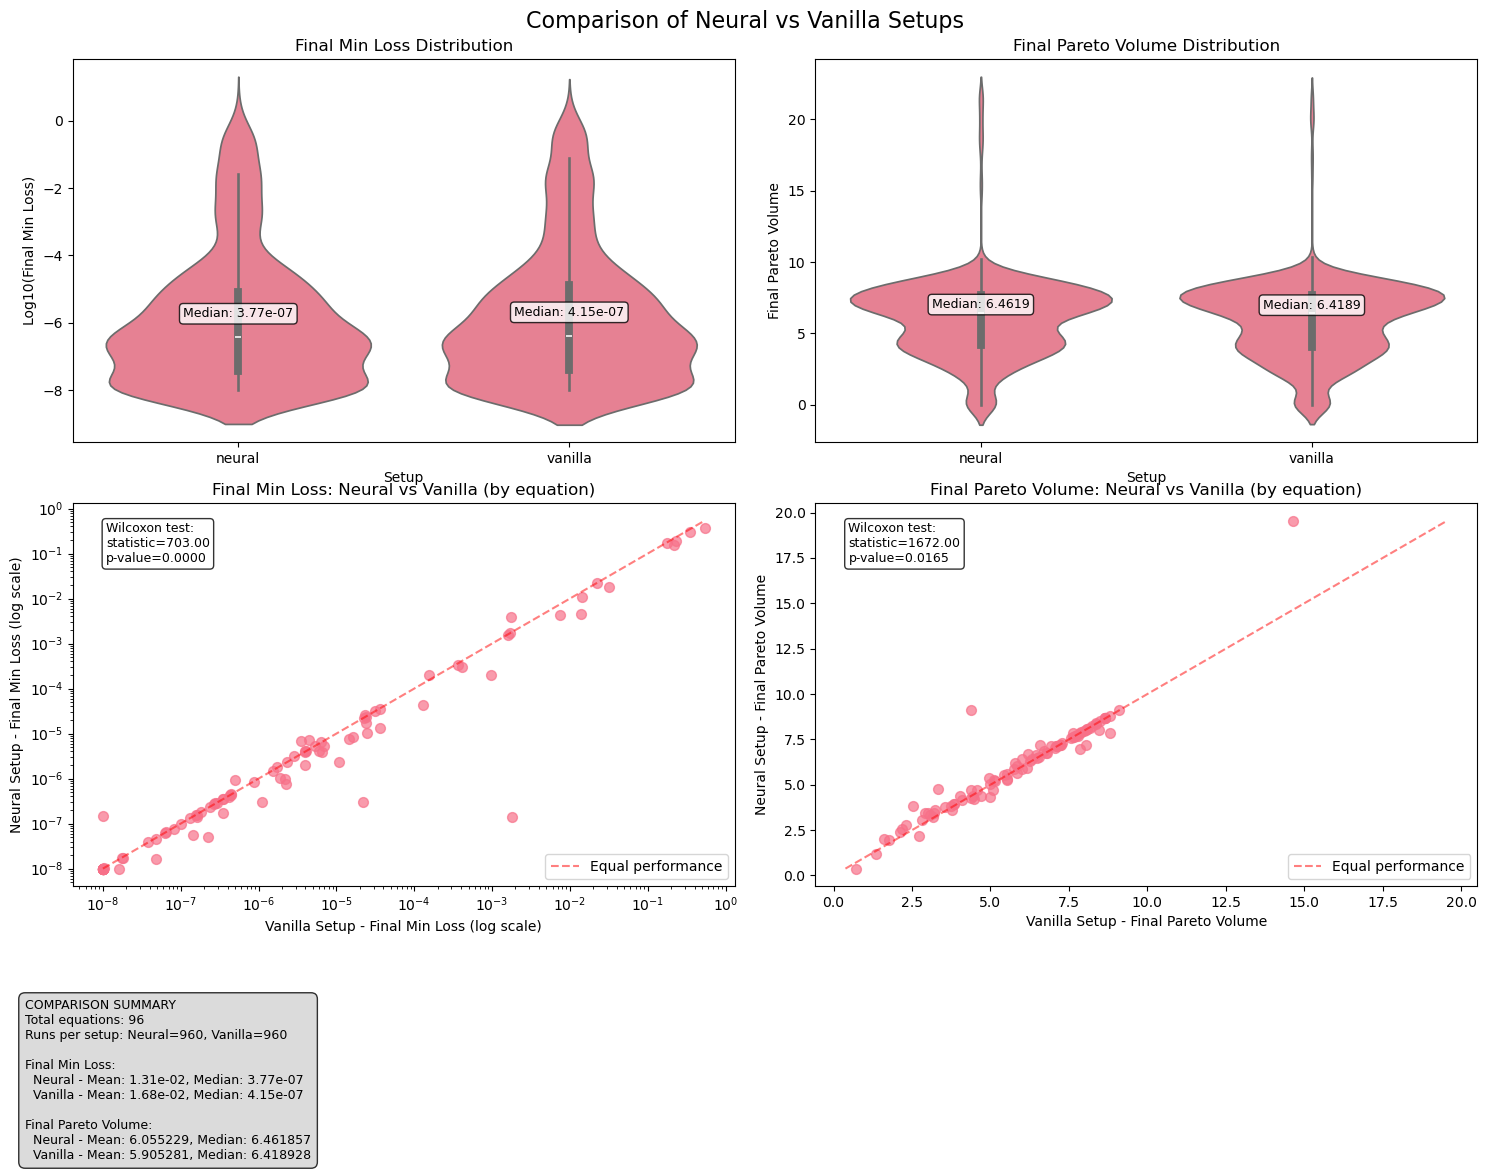

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Comparison of Neural vs Vanilla Setups', fontsize=16, y=0.98)

# Plot 1: Final Min Loss - Violin plot (better for showing distribution shape)
ax1 = axes[0, 0]
# Create violin plot with log scale
log_loss_data = filtered_df.copy()
log_loss_data['log_final_min_loss'] = np.log10(log_loss_data['final_min_loss'])

sns.violinplot(data=log_loss_data, x='setup', y='log_final_min_loss', ax=ax1, inner='box')
ax1.set_title('Final Min Loss Distribution')
ax1.set_ylabel('Log10(Final Min Loss)')
ax1.set_xlabel('Setup')

# Add median values as text
for i, setup in enumerate(['neural', 'vanilla']):
    setup_data = log_loss_data[log_loss_data['setup'] == setup]['log_final_min_loss']
    median_val = setup_data.median()
    ax1.text(i, median_val + 0.5, f'Median: {10**median_val:.2e}', 
             ha='center', va='bottom', fontsize=9, 
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# Plot 2: Final Pareto Volume - Violin plot
ax2 = axes[0, 1]
sns.violinplot(data=filtered_df, x='setup', y='final_pareto_volume', ax=ax2, inner='box')
ax2.set_title('Final Pareto Volume Distribution')
ax2.set_ylabel('Final Pareto Volume')
ax2.set_xlabel('Setup')

# Add median values as text
for i, setup in enumerate(['neural', 'vanilla']):
    setup_data = filtered_df[filtered_df['setup'] == setup]['final_pareto_volume']
    median_val = setup_data.median()
    ax2.text(i, median_val + 0.1, f'Median: {median_val:.4f}', 
             ha='center', va='bottom', fontsize=9,
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# Plot 3: Final Min Loss - Scatter plot by equation
ax3 = axes[1, 0]
# Create pivot table for scatter plot
loss_pivot = summary_stats.pivot_table(
    index=['dataset', 'eq'], 
    columns='setup', 
    values='final_min_loss_mean'
).reset_index()

if 'neural' in loss_pivot.columns and 'vanilla' in loss_pivot.columns:
    ax3.scatter(loss_pivot['vanilla'], loss_pivot['neural'], alpha=0.7, s=50)
    ax3.set_xscale('log')
    ax3.set_yscale('log')
    
    # Add diagonal line for reference
    min_val = min(loss_pivot['vanilla'].min(), loss_pivot['neural'].min())
    max_val = max(loss_pivot['vanilla'].max(), loss_pivot['neural'].max())
    ax3.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='Equal performance')
    
    ax3.set_xlabel('Vanilla Setup - Final Min Loss (log scale)')
    ax3.set_ylabel('Neural Setup - Final Min Loss (log scale)')
    ax3.set_title('Final Min Loss: Neural vs Vanilla (by equation)')
    
    # Add Wilcoxon test result
    loss_stat, loss_pval = stats.wilcoxon(loss_pivot['neural'], loss_pivot['vanilla'])
    ax3.text(0.05, 0.95, f'Wilcoxon test:\nstatistic={loss_stat:.2f}\np-value={loss_pval:.4f}', 
             transform=ax3.transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    ax3.legend()

# Plot 4: Final Pareto Volume - Scatter plot by equation
ax4 = axes[1, 1]
volume_pivot = summary_stats.pivot_table(
    index=['dataset', 'eq'], 
    columns='setup', 
    values='final_pareto_volume_mean'
).reset_index()

if 'neural' in volume_pivot.columns and 'vanilla' in volume_pivot.columns:
    ax4.scatter(volume_pivot['vanilla'], volume_pivot['neural'], alpha=0.7, s=50)
    
    # Add diagonal line for reference
    min_val = min(volume_pivot['vanilla'].min(), volume_pivot['neural'].min())
    max_val = max(volume_pivot['vanilla'].max(), volume_pivot['neural'].max())
    ax4.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='Equal performance')
    
    ax4.set_xlabel('Vanilla Setup - Final Pareto Volume')
    ax4.set_ylabel('Neural Setup - Final Pareto Volume')
    ax4.set_title('Final Pareto Volume: Neural vs Vanilla (by equation)')
    
    # Add Wilcoxon test result
    volume_stat, volume_pval = stats.wilcoxon(volume_pivot['neural'], volume_pivot['vanilla'])
    ax4.text(0.05, 0.95, f'Wilcoxon test:\nstatistic={volume_stat:.2f}\np-value={volume_pval:.4f}', 
             transform=ax4.transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    ax4.legend()

# Add summary statistics to the figure
neural_loss = filtered_df[filtered_df['setup'] == 'neural']['final_min_loss']
vanilla_loss = filtered_df[filtered_df['setup'] == 'vanilla']['final_min_loss']
neural_volume = filtered_df[filtered_df['setup'] == 'neural']['final_pareto_volume']
vanilla_volume = filtered_df[filtered_df['setup'] == 'vanilla']['final_pareto_volume']

summary_text = f"""COMPARISON SUMMARY
Total equations: {filtered_df['eq'].nunique()}
Runs per setup: Neural={len(neural_loss)}, Vanilla={len(vanilla_loss)}

Final Min Loss:
  Neural - Mean: {neural_loss.mean():.2e}, Median: {neural_loss.median():.2e}
  Vanilla - Mean: {vanilla_loss.mean():.2e}, Median: {vanilla_loss.median():.2e}

Final Pareto Volume:
  Neural - Mean: {neural_volume.mean():.6f}, Median: {neural_volume.median():.6f}
  Vanilla - Mean: {vanilla_volume.mean():.6f}, Median: {vanilla_volume.median():.6f}"""

fig.text(0.02, 0.02, summary_text, fontsize=9, verticalalignment='bottom',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Make room for summary text
plt.show()


=== DIFFICULTY CATEGORIZATION ===
Easy threshold (min loss): 1.97e-07
Medium threshold (min loss): 6.80e-06

Equations per difficulty:
difficulty
Difficult    32
Easy         32
Medium       32
Name: eq, dtype: int64


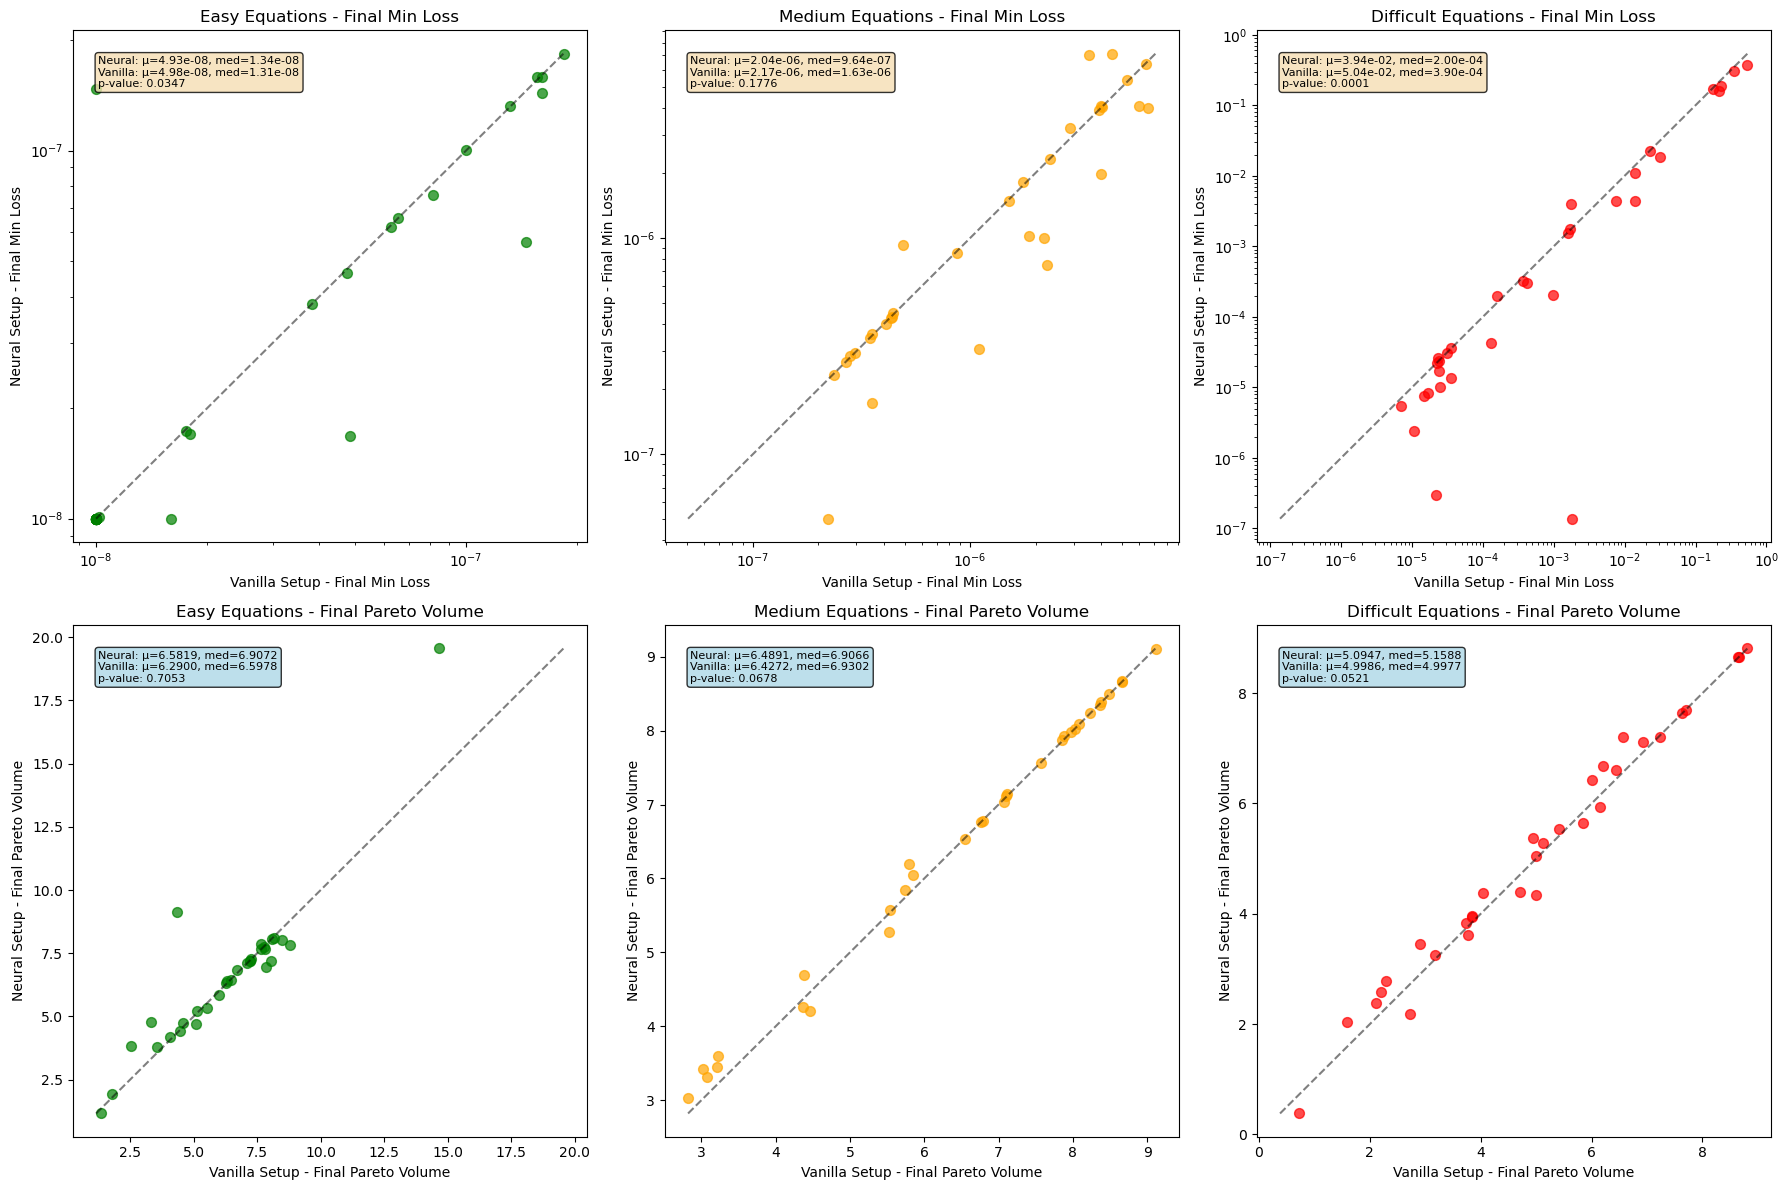


=== DETAILED STATISTICS BY DIFFICULTY ===

EASY EQUATIONS:
  Number of equations: 32
  Final Min Loss:
    Neural - Mean: 4.93e-08, Median: 1.00e-08
    Vanilla - Mean: 4.98e-08, Median: 1.00e-08
  Final Pareto Volume:
    Neural - Mean: 6.581887, Median: 6.603150
    Vanilla - Mean: 6.290035, Median: 6.880632

MEDIUM EQUATIONS:
  Number of equations: 32
  Final Min Loss:
    Neural - Mean: 2.04e-06, Median: 4.61e-07
    Vanilla - Mean: 2.17e-06, Median: 7.56e-07
  Final Pareto Volume:
    Neural - Mean: 6.489067, Median: 7.070149
    Vanilla - Mean: 6.427193, Median: 7.081555

DIFFICULT EQUATIONS:
  Number of equations: 32
  Final Min Loss:
    Neural - Mean: 3.94e-02, Median: 4.02e-05
    Vanilla - Mean: 5.04e-02, Median: 9.57e-05
  Final Pareto Volume:
    Neural - Mean: 5.094732, Median: 5.019256
    Vanilla - Mean: 4.998617, Median: 4.980862


In [30]:
# Categorize equations by difficulty based on vanilla setup performance
vanilla_eq_performance = filtered_df[filtered_df['setup'] == 'vanilla'].groupby('eq')['final_min_loss'].mean()

# Define difficulty thresholds (using quantiles)
easy_threshold = vanilla_eq_performance.quantile(0.33)
medium_threshold = vanilla_eq_performance.quantile(0.67)

def categorize_difficulty(eq_id):
    avg_loss = vanilla_eq_performance[eq_id]
    if avg_loss <= easy_threshold:
        return 'Easy'
    elif avg_loss <= medium_threshold:
        return 'Medium'
    else:
        return 'Difficult'

# Add difficulty category to dataframe
filtered_df['difficulty'] = filtered_df['eq'].apply(categorize_difficulty)

print("=== DIFFICULTY CATEGORIZATION ===")
print(f"Easy threshold (min loss): {easy_threshold:.2e}")
print(f"Medium threshold (min loss): {medium_threshold:.2e}")
print("\nEquations per difficulty:")
print(filtered_df.groupby('difficulty')['eq'].nunique())

# Create comparison plots for each difficulty category
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

difficulties = ['Easy', 'Medium', 'Difficult']
colors = ['green', 'orange', 'red']

for i, difficulty in enumerate(difficulties):
    # Filter data for this difficulty
    diff_data = filtered_df[filtered_df['difficulty'] == difficulty]
    
    # Create pivot tables for this difficulty
    loss_pivot_diff = diff_data.pivot_table(
        index='eq', columns='setup', values='final_min_loss', aggfunc='mean'
    ).dropna()
    
    volume_pivot_diff = diff_data.pivot_table(
        index='eq', columns='setup', values='final_pareto_volume', aggfunc='mean'
    ).dropna()
    
    # Plot 1: Final Min Loss comparison
    ax1 = axes[0, i]
    if 'neural' in loss_pivot_diff.columns and 'vanilla' in loss_pivot_diff.columns:
        ax1.scatter(loss_pivot_diff['vanilla'], loss_pivot_diff['neural'], 
                   alpha=0.7, s=50, color=colors[i])
        
        # Add diagonal line
        min_val = min(loss_pivot_diff['vanilla'].min(), loss_pivot_diff['neural'].min())
        max_val = max(loss_pivot_diff['vanilla'].max(), loss_pivot_diff['neural'].max())
        ax1.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
        
        # Calculate statistics
        neural_vals = loss_pivot_diff['neural']
        vanilla_vals = loss_pivot_diff['vanilla']
        
        neural_mean = neural_vals.mean()
        neural_median = neural_vals.median()
        vanilla_mean = vanilla_vals.mean()
        vanilla_median = vanilla_vals.median()
        
        # Wilcoxon test
        if len(neural_vals) > 0 and len(vanilla_vals) > 0:
            stat, pval = stats.wilcoxon(neural_vals, vanilla_vals)
            
            # Add text box with statistics
            textstr = f'Neural: μ={neural_mean:.2e}, med={neural_median:.2e}\n'
            textstr += f'Vanilla: μ={vanilla_mean:.2e}, med={vanilla_median:.2e}\n'
            textstr += f'p-value: {pval:.4f}'
            
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
            ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=8,
                    verticalalignment='top', bbox=props)
    
    ax1.set_xlabel('Vanilla Setup - Final Min Loss')
    ax1.set_ylabel('Neural Setup - Final Min Loss')
    ax1.set_title(f'{difficulty} Equations - Final Min Loss')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    
    # Plot 2: Final Pareto Volume comparison
    ax2 = axes[1, i]
    if 'neural' in volume_pivot_diff.columns and 'vanilla' in volume_pivot_diff.columns:
        ax2.scatter(volume_pivot_diff['vanilla'], volume_pivot_diff['neural'], 
                   alpha=0.7, s=50, color=colors[i])
        
        # Add diagonal line
        min_val = min(volume_pivot_diff['vanilla'].min(), volume_pivot_diff['neural'].min())
        max_val = max(volume_pivot_diff['vanilla'].max(), volume_pivot_diff['neural'].max())
        ax2.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
        
        # Calculate statistics
        neural_vals = volume_pivot_diff['neural']
        vanilla_vals = volume_pivot_diff['vanilla']
        
        neural_mean = neural_vals.mean()
        neural_median = neural_vals.median()
        vanilla_mean = vanilla_vals.mean()
        vanilla_median = vanilla_vals.median()
        
        # Wilcoxon test
        if len(neural_vals) > 0 and len(vanilla_vals) > 0:
            stat, pval = stats.wilcoxon(neural_vals, vanilla_vals)
            
            # Add text box with statistics
            textstr = f'Neural: μ={neural_mean:.4f}, med={neural_median:.4f}\n'
            textstr += f'Vanilla: μ={vanilla_mean:.4f}, med={vanilla_median:.4f}\n'
            textstr += f'p-value: {pval:.4f}'
            
            props = dict(boxstyle='round', facecolor='lightblue', alpha=0.8)
            ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=8,
                    verticalalignment='top', bbox=props)
    
    ax2.set_xlabel('Vanilla Setup - Final Pareto Volume')
    ax2.set_ylabel('Neural Setup - Final Pareto Volume')
    ax2.set_title(f'{difficulty} Equations - Final Pareto Volume')

plt.tight_layout()
plt.show()

# Print detailed statistics by difficulty
print("\n=== DETAILED STATISTICS BY DIFFICULTY ===")
for difficulty in difficulties:
    print(f"\n{difficulty.upper()} EQUATIONS:")
    diff_data = filtered_df[filtered_df['difficulty'] == difficulty]
    
    neural_data = diff_data[diff_data['setup'] == 'neural']
    vanilla_data = diff_data[diff_data['setup'] == 'vanilla']
    
    print(f"  Number of equations: {diff_data['eq'].nunique()}")
    print(f"  Final Min Loss:")
    print(f"    Neural - Mean: {neural_data['final_min_loss'].mean():.2e}, Median: {neural_data['final_min_loss'].median():.2e}")
    print(f"    Vanilla - Mean: {vanilla_data['final_min_loss'].mean():.2e}, Median: {vanilla_data['final_min_loss'].median():.2e}")
    
    print(f"  Final Pareto Volume:")
    print(f"    Neural - Mean: {neural_data['final_pareto_volume'].mean():.6f}, Median: {neural_data['final_pareto_volume'].median():.6f}")
    print(f"    Vanilla - Mean: {vanilla_data['final_pareto_volume'].mean():.6f}, Median: {vanilla_data['final_pareto_volume'].median():.6f}")
